In [1]:
# 라이브러리 불러오기
from pykrx import stock
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime


# Data Prerprocessing
samsung_code = "005930"    
skhynix_code = "000660"  

start_date = "2017-10-19"
end_date = "2019-10-31"

samsung_df = stock.get_market_ohlcv_by_date(start_date, end_date, samsung_code)
skhynix_df = stock.get_market_ohlcv_by_date(start_date, end_date, skhynix_code)


df = pd.DataFrame({'samsung': samsung_df['종가'], 'skhynix': skhynix_df['종가']}).astype(float)

# Risk Free Rate
rf_df = pd.read_csv("/Users/pjy97/Desktop/한양대/1-1/금융공학및위험관리/기말/DeltaHedging/국채금리.CSV", encoding='CP949', index_col=0)
rf_df.drop(columns=['10year'], inplace=True)
rf_df.index = pd.to_datetime(rf_df.index)
rf_df = rf_df.loc[df.index]





In [2]:
# Monte Carlo Simulation
def monte_carlo_simulation(drift, volatility, epsilon, num_assets):
    dt = 1/247  # 일일 시간 간격
    log_returns = []
    for i in range(num_assets):
        log_return = (drift - 0.5 * volatility[i]**2) * dt + volatility[i] * np.sqrt(dt) * epsilon[i]
        log_returns.append(log_return)
    return np.array(log_returns)

In [3]:
def find_f(worst_performer, index, rf, first, second, third, due_first, due_second, due_third, due_last, EC_strike_rate, first_payoff, second_payoff, third_payoff, f):
    initial_price = 10000
    if index < first and worst_performer[due_first] > EC_strike_rate:
        f.append(first_payoff*initial_price / np.exp(rf/247 * due_first))
    elif index < second and worst_performer[due_second] > EC_strike_rate:
        f.append(second_payoff*initial_price / np.exp(rf/247 * due_second))
    elif index < third and worst_performer[due_third] > EC_strike_rate:
        f.append(third_payoff*initial_price / np.exp(rf/247 * due_third))                  
    else:
        worst_mean = (worst_performer[due_last-2] + worst_performer[due_last-1] + worst_performer[due_last])/3
        max_return = max(worst_mean, 0.95)
        f.append(max_return*initial_price / np.exp(rf/247 * due_last))
    return

In [4]:
num_assets = 2
time_steps = 247
num_samples = 10000
# rf = 0.02

df_index = df.iloc[252::5, :]
initial_price = df.iloc[252]
EC_strike_rate = 1.02
MC_strike_rate = 1.00
EC_strike_price = initial_price * EC_strike_rate
MC_strike_price = initial_price * MC_strike_rate
dt = 5/247

ELS_Delta1 = []
ELS_Delta2 = []

### 2018-10-31부터 20일단위로 rebalancing 진행
for index, names in df_index.iterrows():
    rf = rf_df.loc[index][0]/100
    simulated_S = []
    simulated_Su = []
    simulated_Sd = []
    
    # 리밸런싱 시점의 252 영업일 전부터의 데이터 가져오기
    init_price = df.loc[index]
    index_num = df.index.get_loc(index)
    df_hist = df.iloc[index_num-252:index_num, :]
        
    # MCMC로 10000개의 (2, 252) 누적 수익률 데이터 만들기
    cholesky_mat = np.linalg.cholesky(df_hist.corr())
    vol = np.log(df_hist/df_hist.shift(1))[1:].std() * np.sqrt(247)
        
    for _ in range(num_samples):                        
        epsilon = np.dot(cholesky_mat, np.random.randn(num_assets, time_steps))
        simulated_returns = monte_carlo_simulation(rf, vol, epsilon, num_assets)
        
        S = np.exp(np.cumsum((simulated_returns), axis=1))
        S = np.insert(S, 0, 1.0, axis=1)[:, :-1]        
      
        Su = S.copy()
        Su[0] *= np.exp(vol[0]*np.sqrt(5*dt))
        Su[1] *= np.exp(vol[1]*np.sqrt(5*dt))
        Sd = S.copy()
        Sd[0] *= np.exp(-1*vol[0]*np.sqrt(5*dt))
        Sd[1] *= np.exp(-1*vol[1]*np.sqrt(dt))
        
        simulated_S.append(S)
        simulated_Su.append(Su)
        simulated_Sd.append(Sd)
                
    simulated_S = np.array(simulated_S)
    simulated_Su = np.array(simulated_Su)
    simulated_Sd = np.array(simulated_Sd)       
    
    # Correlation 고려하며 path가 생성되었는지 확인
    coef = []
    for a in simulated_S:
        coef.append(np.corrcoef(a)[0, 1])
    print("generated path의 correlation 평균 :", sum(coef)/len(simulated_S))
    print("historical path의 correlation :", df_hist.corr().iloc[0, 1])
    print("Samsung historical volatility :", vol[0])
    print("SKhynix historical volatility :", vol[1])
    print()
    ### ELS 가치평가
    first = datetime.strptime('2019-01-31', '%Y-%m-%d')
    second = datetime.strptime('2019-04-30', '%Y-%m-%d')
    third = datetime.strptime('2019-07-31', '%Y-%m-%d')
    last = datetime.strptime('2019-10-31', '%Y-%m-%d')
    
    f1_up = []
    f1_down = []
    f2_up = []
    f2_down = []
        
    first_payoff = 1.0159
    second_payoff = 1.0318
    third_payoff = 1.0477
        
    due_first = len(df.loc[:first]) - len(df.loc[:index])
    due_second = len(df.loc[:second]) - len(df.loc[:index])
    due_third = len(df.loc[:third]) - len(df.loc[:index])
    due_last = len(df.loc[:last]) - len(df.loc[:index])
        
    for S, Su, Sd in zip(simulated_S, simulated_Su, simulated_Sd):        
        
        # f1_up 구하기 : 기초자산1 상승, 기초자산2 불변        
        worst_performer = np.min(np.vstack((Su[0], S[1])), axis=0)
        find_f(worst_performer, index, rf, first, second, third, due_first, due_second, due_third, due_last, EC_strike_rate, first_payoff, second_payoff, third_payoff, f1_up)        
        
        # f1_down 구하기 : 기초자산1 하락, 기초자산2 불변
        worst_performer = np.min(np.vstack((Sd[0], S[1])), axis=0)
        find_f(worst_performer, index, rf, first, second, third, due_first, due_second, due_third, due_last, EC_strike_rate, first_payoff, second_payoff, third_payoff, f1_down)        
                
        # f2_up 구하기 : 기초자산1 불변, 기초자산2 상승
        worst_performer = np.min(np.vstack((S[0], Su[1])), axis=0)
        find_f(worst_performer, index, rf, first, second, third, due_first, due_second, due_third, due_last, EC_strike_rate, first_payoff, second_payoff, third_payoff, f2_up)        
        
        # f2_down 구하기 : 기초자산1 불변, 기초자산2 하락
        worst_performer = np.min(np.vstack((S[0], Sd[1])), axis=0)
        find_f(worst_performer, index, rf, first, second, third, due_first, due_second, due_third, due_last, EC_strike_rate, first_payoff, second_payoff, third_payoff, f2_down)        
        
    # Els Delta 구하기    
    f1_up = sum(f1_up)/num_samples
    f1_down = sum(f1_down)/num_samples
    f2_up = sum(f2_up)/num_samples
    f2_down = sum(f2_down)/num_samples
    

    delta_1 = ((f1_up - f1_down)/10000) / ((init_price[0] * np.exp(vol[0]*np.sqrt(5*dt)) - init_price[0] * np.exp(-1*vol[0]*np.sqrt(5*dt)))/init_price[0])
    delta_2 = ((f2_up - f2_down)/10000) / ((init_price[1] * np.exp(vol[1]*np.sqrt(5*dt)) - init_price[1] * np.exp(-1*vol[1]*np.sqrt(5*dt)))/init_price[1])
    ELS_Delta1.append(delta_1)
    ELS_Delta2.append(delta_2)

/var/folders/zp/_86qtd3j3ms644g4k0pnwc_c0000gn/T/ipykernel_15300/1379325861.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rf = rf_df.loc[index][0]/100
/var/folders/zp/_86qtd3j3ms644g4k0pnwc_c0000gn/T/ipykernel_15300/2284293445.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  log_return = (drift - 0.5 * volatility[i]**2) * dt + volatility[i] * np.sqrt(dt) * epsilon[i]
/var/folders/zp/_86qtd3j3ms644g4k0pnwc_c0000gn/T/ipykernel_15300/1379325861.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with D

generated path의 correlation 평균 : 0.37991747345474425
historical path의 correlation : 0.4299169774400851
Samsung historical volatility : 0.2720331125338899
SKhynix historical volatility : 0.3560720926642955



/var/folders/zp/_86qtd3j3ms644g4k0pnwc_c0000gn/T/ipykernel_15300/1379325861.py:61: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Samsung historical volatility :", vol[0])
/var/folders/zp/_86qtd3j3ms644g4k0pnwc_c0000gn/T/ipykernel_15300/1379325861.py:62: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("SKhynix historical volatility :", vol[1])
/var/folders/zp/_86qtd3j3ms644g4k0pnwc_c0000gn/T/ipykernel_15300/1379325861.py:109: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To 

generated path의 correlation 평균 : 0.42662012759431656
historical path의 correlation : 0.46530047179531936
Samsung historical volatility : 0.2741355242247328
SKhynix historical volatility : 0.3553866930370513

generated path의 correlation 평균 : 0.4495136250851801
historical path의 correlation : 0.4900367751267014
Samsung historical volatility : 0.2710287109810036
SKhynix historical volatility : 0.3547859878490109

generated path의 correlation 평균 : 0.46732412541757995
historical path의 correlation : 0.5194490184287702
Samsung historical volatility : 0.27132096899348485
SKhynix historical volatility : 0.35736245835206154

generated path의 correlation 평균 : 0.5040304973756035
historical path의 correlation : 0.5593067257173059
Samsung historical volatility : 0.27180897827948686
SKhynix historical volatility : 0.3579631315844276

generated path의 correlation 평균 : 0.5333313622114185
historical path의 correlation : 0.5849386745066858
Samsung historical volatility : 0.2758565786836702
SKhynix historical vo

In [5]:
print("Asset 1\n", ELS_Delta1)
print("Asset 2\n", ELS_Delta2)

Asset 1
 [0.09510860163339668, 0.0924757013528949, 0.09298512708370732, 0.09587373279457499, 0.0950706046895745, 0.10157602226759252, 0.10115431848498471, 0.10587643662863536, 0.10835602981050907, 0.11283231540990214, 0.11659733823441017, 0.1203664641206065, 0.1275153061803665, 0.10655860306071464, 0.10895326604240614, 0.11082574794381625, 0.11784278689101842, 0.12501295011133562, 0.12394697741637625, 0.13667794776544095, 0.14100681161655837, 0.15049156809649075, 0.16413852485032507, 0.18177691718596445, 0.17400092922817184, 0.1557399255815758, 0.16347945987285745, 0.16148237547463098, 0.1720380421859857, 0.18073602175725068, 0.19003064341971898, 0.20479929977757863, 0.22070419522197565, 0.23262141208204457, 0.24724793581893822, 0.26830495249890196, 0.2995358363128019, 0.3426218131197891, 0.32757469302721703, 0.336768534586535, 0.3285039953762512, 0.33153099067507147, 0.32778191377382404, 0.3305085105908434, 0.32823049339643723, 0.34170699286027145, 0.3374243865629937, 0.33732995983651

In [6]:
df_index['samsung_delta'] = ELS_Delta1
df_index['skhynix_delta'] = ELS_Delta2

/var/folders/zp/_86qtd3j3ms644g4k0pnwc_c0000gn/T/ipykernel_15300/2963218304.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_index['samsung_delta'] = ELS_Delta1
/var/folders/zp/_86qtd3j3ms644g4k0pnwc_c0000gn/T/ipykernel_15300/2963218304.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_index['skhynix_delta'] = ELS_Delta2


In [7]:
# Delta Hedging
df_index['samsung_delta'] = ELS_Delta1
df_index['skhynix_delta'] = ELS_Delta2

# ELS 투자금 100억
start_price = 1e10

# 거래비용 및 판매 비용
buy_transaction_cost_rate = 0.0015
transaction_tax = 0.002
sell_transaction_cost_rate = transaction_tax+buy_transaction_cost_rate

# 델타 변화량
df_index['samsung_delta_change'] = df_index['samsung_delta'].diff()
df_index['skhynix_delta_change'] = df_index['skhynix_delta'].diff()


df_index['samsung_delta_change'][0] = df_index['samsung_delta'][0]
df_index['skhynix_delta_change'][0] = df_index['skhynix_delta'][0]


# 조기상환일 지정
first_date = datetime.strptime('2019-01-31', '%Y-%m-%d')
second_date = datetime.strptime('2019-04-30', '%Y-%m-%d')
third_date = datetime.strptime('2019-07-31', '%Y-%m-%d')


# 조기상환일마다 헷징 상태를 넣기 위한 데이터 생성
df_index.loc[first_date] = [np.NaN] * len(df_index.columns)
df_index.loc[second_date] = [np.NaN] * len(df_index.columns)
df_index.loc[third_date] = [np.NaN] * len(df_index.columns)
df_index.sort_index(inplace=True)

# 데이터 프레임에 주식 정보 추가
df_index.loc[first_date] = df.loc[first_date]
df_index.loc[second_date] = df.loc[first_date]
df_index.loc[third_date] = df.loc[first_date]

# 삼성전자, skhynix 주식 수익률
samsung_init_price = df_index['samsung'][0]
skhynix_init_price = df_index['skhynix'][0]

df_index['samsung_return'] = df_index['samsung'] / samsung_init_price
df_index['skhynix_return'] = df_index['skhynix'] / skhynix_init_price


# 각 기간별 risk Free Rate 추가
df_index['rf'] = rf_df['3year'].loc[df_index.index]





/var/folders/zp/_86qtd3j3ms644g4k0pnwc_c0000gn/T/ipykernel_15300/121220673.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_index['samsung_delta'] = ELS_Delta1
/var/folders/zp/_86qtd3j3ms644g4k0pnwc_c0000gn/T/ipykernel_15300/121220673.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_index['skhynix_delta'] = ELS_Delta2
/var/folders/zp/_86qtd3j3ms644g4k0pnwc_c0000gn/T/ipykernel_15300/121220673.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

In [8]:
def init_start(data, stock_name, delta, invest_price, buy_transaction_cost_rate, stock_nums, invest_moneys, remain_moneys, costs, start_invest_price):
    """
    처음에 투자할 주식 수 및 투자금, 현금보유량, 거래세를 계산하는 함수
    
    input : 
        data : 데이터 프레임
        stock_name : 주식 이름
        delta : 델타 이름
        invest_price : 투자금 50억
        buy_transaction_cost_rate : 거래비용
        stock_nums : 주식 수
        invest_moneys : 투자금
        remain_moneys : 현금보유량
        costs : 거래비용
        start_invest_price : 초기 투자금 50억
    output :
        stock_nums : 주식 수
        invest_moneys : 투자금
        remain_moneys : 현금보유량
        costs : 거래비용
    """
    
    stock_num = np.round(data[delta] * invest_price / data[stock_name], 0)
    
    invest_money = stock_num * data[stock_name]
    transaction_cost = invest_money * buy_transaction_cost_rate
    remain_money = start_invest_price - invest_money - transaction_cost
    stock_nums.append(stock_num)
    invest_moneys.append(invest_money)
    remain_moneys.append(remain_money)
    costs.append(transaction_cost)
    start_invest_price = remain_money
    return stock_nums, invest_moneys, remain_moneys, costs

In [9]:
def sell_stock(data, stock_name, delta, sell_transaction_cost_rate, stock_nums, invest_moneys, remain_moneys, costs):
    """
    델타 변화에 따라 주식을 팔고 현금을 보유하는 함수

    input :
        data : 데이터 프레임
        stock_name : 주식 이름
        delta : 델타 이름
        sell_transaction_cost_rate : 거래비용
        stock_nums : 주식 수
        invest_moneys : 투자금
        remain_moneys : 현금보유량
        costs : 거래비용

    output :
        stock_nums : 주식 수
        invest_moneys : 투자금
        remain_moneys : 현금보유량
        costs : 거래비용
    """


    stock_nu = np.round(abs(data[delta]) * stock_nums[-1], 0)

    now_invest_money = stock_nu * data[stock_name]
    # 거래비용
    transaction_cost = now_invest_money * sell_transaction_cost_rate

    invest_money = invest_moneys[-1] - now_invest_money
    # 남은 돈
  
    now_remain_money = remain_moneys[-1] - now_invest_money - transaction_cost

    
    stock_num = stock_nums[-1] - stock_nu
    stock_nums.append(stock_num)
    invest_moneys.append(invest_money)
    remain_moneys.append(now_remain_money)
    costs.append(transaction_cost)
    return stock_nums, invest_moneys, remain_moneys, costs

In [10]:
def buy_stock(data, stock_name, delta, transaction_cost_rate, stock_nums, invest_moneys, remain_moneys, costs):
    """
    델타 변화에 따라 주식을 사고 현금을 보유하는 함수

    input :
        data : 데이터 프레임
        stock_name : 주식 이름
        delta : 델타 이름
        transaction_cost_rate : 거래비용
        stock_nums : 주식 수
        invest_moneys : 투자금
        remain_moneys : 현금보유량
        costs : 거래비용
    
    output :
        stock_nums : 주식 수
        invest_moneys : 투자금
        remain_moneys : 현금보유량
        costs : 거래비용

    """
    stock_nu = np.round(abs(data[delta]) * stock_nums[-1], 0)
    now_invest_money = stock_nu * data[stock_name]
    # now_invest_money
    transaction_cost = now_invest_money * transaction_cost_rate
    # 남은 돈
    remain_money = remain_moneys[-1] - now_invest_money - transaction_cost
    # 보유 주식 수
    stock_num = stock_nums[-1] + stock_nu
    # 투자 금
    now_invest_money = invest_moneys[-1] + now_invest_money
    stock_nums.append(stock_num)
    invest_moneys.append(now_invest_money)
    remain_moneys.append(remain_money)
    costs.append(transaction_cost)

    return stock_nums, invest_moneys, remain_moneys, costs

In [11]:
# 삼성에 대해서만 수행
samsung_start_invest_price = start_price/2
samsung_stock_nums = []
samsung_invest_moneys = []
samsung_remain_moneys = []
samsung_costs = []
EC_strike_rate = 1.02

for idx, (date, row) in enumerate(df_index.iterrows()):
    # 처음 시작할 때
    print(date)
    if idx == 0:
        samsung_stock_nums, samsung_invest_moneys, samsung_remain_moneys, samsung_costs = init_start(
            data=row, stock_name='samsung', delta='samsung_delta', invest_price=samsung_start_invest_price, 
            buy_transaction_cost_rate=buy_transaction_cost_rate, stock_nums=samsung_stock_nums, 
            invest_moneys=samsung_invest_moneys,remain_moneys=samsung_remain_moneys, costs=samsung_costs, start_invest_price=samsung_start_invest_price)       

        rf = (1 + row['rf'] / 100) ** (5 / 252) 
    # 조기 상환 마감일일 경우
    # 각 주식의 수익률이 EC_strike_rate보다 높으면 조기상환
    # 조기상환일 경우에는 삼성전자, 하이닉스 주식을 팔고, 이자를 받는다.
    # 조기상환이 아닐 경우 다음 index로 넘어간다.
    elif date == first_date or idx == second_date or idx == third_date:

        # 이전값들을 붙여 넣는다.
        samsung_stock_nums.append(samsung_stock_nums[-1])
        samsung_invest_moneys.append(samsung_invest_moneys[-1])
        samsung_remain_moneys.append(samsung_remain_moneys[-1])
        samsung_costs.append(samsung_costs[-1])
        samsung_start_invest_price = samsung_remain_moneys[-1]

        # 조기상환 조건을 만족하면 break
        if row['samsung_return'] > EC_strike_rate and row['skhynix_return'] > EC_strike_rate:
            break
        # 조기상환이 아닐경우 넘어간다.
        else:
            pass
    # 조기상환이 아닐 경우
    else:
        # 팔아야할 경우
        if row['samsung_delta_change'] < 0:
            print("sell samsung", row['samsung_delta_change'])
            samsung_stock_nums, samsung_invest_moneys, samsung_remain_moneys, samsung_costs = sell_stock(
                data=row, stock_name='samsung', delta='samsung_delta_change', sell_transaction_cost_rate=sell_transaction_cost_rate, 
                stock_nums=samsung_stock_nums, invest_moneys=samsung_invest_moneys, remain_moneys=samsung_remain_moneys, 
                costs=samsung_costs)
            samsung_remain_moneys[-1] = samsung_remain_moneys[-1] * (rf)

        elif row['samsung_delta_change'] > 0:
            print("buy samsung", row['samsung_delta_change'])

            samsung_stock_nums, samsung_invest_moneys, samsung_remain_moneys, samsung_costs = buy_stock(
                data=row, stock_name='samsung', delta='samsung_delta_change', transaction_cost_rate=buy_transaction_cost_rate, 
                stock_nums=samsung_stock_nums, invest_moneys=samsung_invest_moneys, remain_moneys=samsung_remain_moneys, 
                costs=samsung_costs)
            samsung_remain_moneys[-1] = samsung_remain_moneys[-1] * (rf)
                  
        rf = (1 + row['rf'] / 100) ** (5 / 252)



    

2018-10-31 00:00:00
2018-11-07 00:00:00
sell samsung -0.002632900280501782
2018-11-14 00:00:00
buy samsung 0.0005094257308124184
2018-11-21 00:00:00
buy samsung 0.0028886057108676727
2018-11-28 00:00:00
sell samsung -0.0008031281050004946
2018-12-05 00:00:00
buy samsung 0.006505417578018022
2018-12-12 00:00:00
sell samsung -0.0004217037826078074
2018-12-19 00:00:00
buy samsung 0.004722118143650644
2018-12-27 00:00:00
buy samsung 0.0024795931818737127
2019-01-07 00:00:00
buy samsung 0.004476285599393073
2019-01-14 00:00:00
buy samsung 0.003765022824508024
2019-01-21 00:00:00
buy samsung 0.0037691258861963367
2019-01-28 00:00:00
buy samsung 0.007148842059759991
2019-01-31 00:00:00


In [12]:
skhynix_start_invest_price = start_price/2
skhynix_stock_nums = []
skhynix_invest_moneys = []
skhynix_remain_moneys = []
skhynix_costs = []
EC_strike_rate = 1.02

for idx, (date, row) in enumerate(df_index.iterrows()):
    # 처음 시작할 때
    print(date)
    if idx == 0:
        skhynix_stock_nums, skhynix_invest_moneys, skhynix_remain_moneys, skhynix_costs = init_start(
            data=row, stock_name='skhynix', delta='skhynix_delta', invest_price=skhynix_start_invest_price, 
            buy_transaction_cost_rate=buy_transaction_cost_rate, stock_nums=skhynix_stock_nums, 
            invest_moneys=skhynix_invest_moneys, remain_moneys=skhynix_remain_moneys, costs=skhynix_costs, start_invest_price=skhynix_start_invest_price)
        

        rf = (1 + row['rf'] / 100) ** (5 / 252) 
    # 조기 상환 마감일일 경우
    # 각 주식의 수익률이 EC_strike_rate보다 높으면 조기상환
    # 조기상환일 경우에는 삼성전자, 하이닉스 주식을 팔고, 이자를 받는다.
    # 조기상환이 아닐 경우 다음 index로 넘어간다.
    elif date == first_date or idx == second_date or idx == third_date:
        # 하이닉스
        skhynix_stock_nums.append(skhynix_stock_nums[-1])
        skhynix_invest_moneys.append(skhynix_invest_moneys[-1])
        skhynix_remain_moneys.append(skhynix_remain_moneys[-1])
        skhynix_costs.append(skhynix_costs[-1])
        skhynix_start_invest_price = skhynix_remain_moneys[-1]
        # 조기상환 조건을 만족하면 break
        if row['samsung_return'] > EC_strike_rate and row['skhynix_return'] > EC_strike_rate:
            break
        # 조기상환이 아닐경우 넘어간다.
        else:
            pass
    # 조기상환이 아닐 경우
    else:     
        if row['skhynix_delta_change'] < 0:
            skhynix_stock_nums, skhynix_invest_moneys, skhynix_remain_moneys, skhynix_costs = sell_stock(
                data=row, stock_name='skhynix', delta='skhynix_delta_change', sell_transaction_cost_rate=sell_transaction_cost_rate, 
                stock_nums=skhynix_stock_nums, invest_moneys=skhynix_invest_moneys, remain_moneys=skhynix_remain_moneys, 
                costs=skhynix_costs)
        
            skhynix_remain_moneys[-1] = skhynix_remain_moneys[-1] * (rf)

        elif row['skhynix_delta_change'] > 0:
            skhynix_stock_nums, skhynix_invest_moneys, skhynix_remain_moneys, skhynix_costs = buy_stock(
                data=row, stock_name='skhynix', delta='skhynix_delta_change', transaction_cost_rate=buy_transaction_cost_rate, 
                stock_nums=skhynix_stock_nums, invest_moneys=skhynix_invest_moneys, remain_moneys=skhynix_remain_moneys, 
                costs=skhynix_costs)
            skhynix_remain_moneys[-1] = skhynix_remain_moneys[-1] * (rf)
        
        rf = (1 + row['rf'] / 100) ** (5 / 252)



    

2018-10-31 00:00:00
2018-11-07 00:00:00
2018-11-14 00:00:00
2018-11-21 00:00:00
2018-11-28 00:00:00
2018-12-05 00:00:00
2018-12-12 00:00:00
2018-12-19 00:00:00
2018-12-27 00:00:00
2019-01-07 00:00:00
2019-01-14 00:00:00
2019-01-21 00:00:00
2019-01-28 00:00:00
2019-01-31 00:00:00


In [13]:
samsung = pd.DataFrame({'samsung_stock_nums': samsung_stock_nums, 'samsung_invest_moneys': samsung_invest_moneys, 'samsung_remain_moneys': samsung_remain_moneys, 'samsung_costs': samsung_costs})
skhynix = pd.DataFrame({'skhynix_stock_nums': skhynix_stock_nums, 'skhynix_invest_moneys': skhynix_invest_moneys, 'skhynix_remain_moneys': skhynix_remain_moneys, 'skhynix_costs': skhynix_costs})
samsung.set_index(df_index.iloc[:14].index, inplace=True)
skhynix.set_index(df_index.iloc[:14].index, inplace=True)
delatheding = pd.merge(samsung, skhynix, left_index=True, right_index=True)
total = pd.merge(df_index.iloc[:14], delatheding, left_index=True, right_index=True)
total['total_invest_money'] = total['samsung'] * total['samsung_stock_nums'] + total['skhynix'] * total['skhynix_stock_nums']
total['total_remain_money'] = total['samsung_remain_moneys'] + total['skhynix_remain_moneys']
total['total_money'] = total['total_invest_money'] + total['total_remain_money']
samsung_final_stock_money = total.iloc[[-2]]['samsung_stock_nums'] * total.iloc[[-1]]['samsung'].values - (sell_transaction_cost_rate * total.iloc[[-2]]['samsung_stock_nums'])
skhynix_final_stock_money = total.iloc[[-2]]['skhynix_stock_nums'] * total.iloc[[-1]]['skhynix'].values - (sell_transaction_cost_rate * total.iloc[[-2]]['skhynix_stock_nums'])
samsung_final_remain_money = total.iloc[[-2]]['samsung_remain_moneys']
skhynix_final_remain_money = total.iloc[[-2]]['skhynix_remain_moneys']
samsung_final_cost = sell_transaction_cost_rate * total.iloc[[-2]]['samsung_stock_nums'] + total['samsung_costs'].iloc[:-1].sum()
skhynix_final_cost = sell_transaction_cost_rate * total.iloc[[-2]]['skhynix_stock_nums'] + total['skhynix_costs'].iloc[:-1].sum()
total.loc[total.index[-1], 'skhynix_stock_nums'] = 0
total.loc[total.index[-1], 'samsung_stock_nums'] = 0
total.loc[total.index[-1], 'samsung_remain_moneys'] = samsung_final_remain_money[0]
total.loc[total.index[-1], 'skhynix_remain_moneys'] = skhynix_final_remain_money[0]
total.loc[total.index[-1], 'samsung_costs'] = samsung_final_cost[0]
total.loc[total.index[-1], 'skhynix_costs'] = skhynix_final_cost[0]
total.loc[total.index[-1], 'total_invest_money'] = 0
total.loc[total.index[-1], 'total_remain_money'] = 0

samsung_final_money = samsung_final_stock_money + samsung_final_remain_money - sell_transaction_cost_rate * total.iloc[[-2]]['samsung_stock_nums']
skhynix_final_money = skhynix_final_stock_money + skhynix_final_remain_money - sell_transaction_cost_rate * total.iloc[[-2]]['skhynix_stock_nums']


total.loc[total.index[-1], 'samsung_invest_moneys'] = samsung_final_money[0]
total.loc[total.index[-1], 'skhynix_invest_moneys'] = skhynix_final_money[0]

total_money = samsung_final_money + skhynix_final_money
total.loc[total.index[-1], 'total_money'] =  total_money[0]

total['total_money'].iloc[-1]

/var/folders/zp/_86qtd3j3ms644g4k0pnwc_c0000gn/T/ipykernel_15300/1809579718.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  total.loc[total.index[-1], 'samsung_remain_moneys'] = samsung_final_remain_money[0]
/var/folders/zp/_86qtd3j3ms644g4k0pnwc_c0000gn/T/ipykernel_15300/1809579718.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  total.loc[total.index[-1], 'skhynix_remain_moneys'] = skhynix_final_remain_money[0]
/var/folders/zp/_86qtd3j3ms644g4k0pnwc_c0000gn/T/ipykernel_15300/1809579718.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will 

10095430166.30835

In [14]:
samsung_price = df.loc['2018-10-31'][0]
skhynix_price = df.loc['2018-10-31'][1]
samsung_strike_price = samsung_price *1.02
skhynix_strike_price = skhynix_price *1.02
df_first = df.loc[:'2019-01-31']
df_first['samsung_return'] = df_first['samsung'] / samsung_price
df_first['skhynix_return']=df_first['skhynix'] / skhynix_price

/var/folders/zp/_86qtd3j3ms644g4k0pnwc_c0000gn/T/ipykernel_15300/2333279450.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  samsung_price = df.loc['2018-10-31'][0]
/var/folders/zp/_86qtd3j3ms644g4k0pnwc_c0000gn/T/ipykernel_15300/2333279450.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  skhynix_price = df.loc['2018-10-31'][1]
/var/folders/zp/_86qtd3j3ms644g4k0pnwc_c0000gn/T/ipykernel_15300/2333279450.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

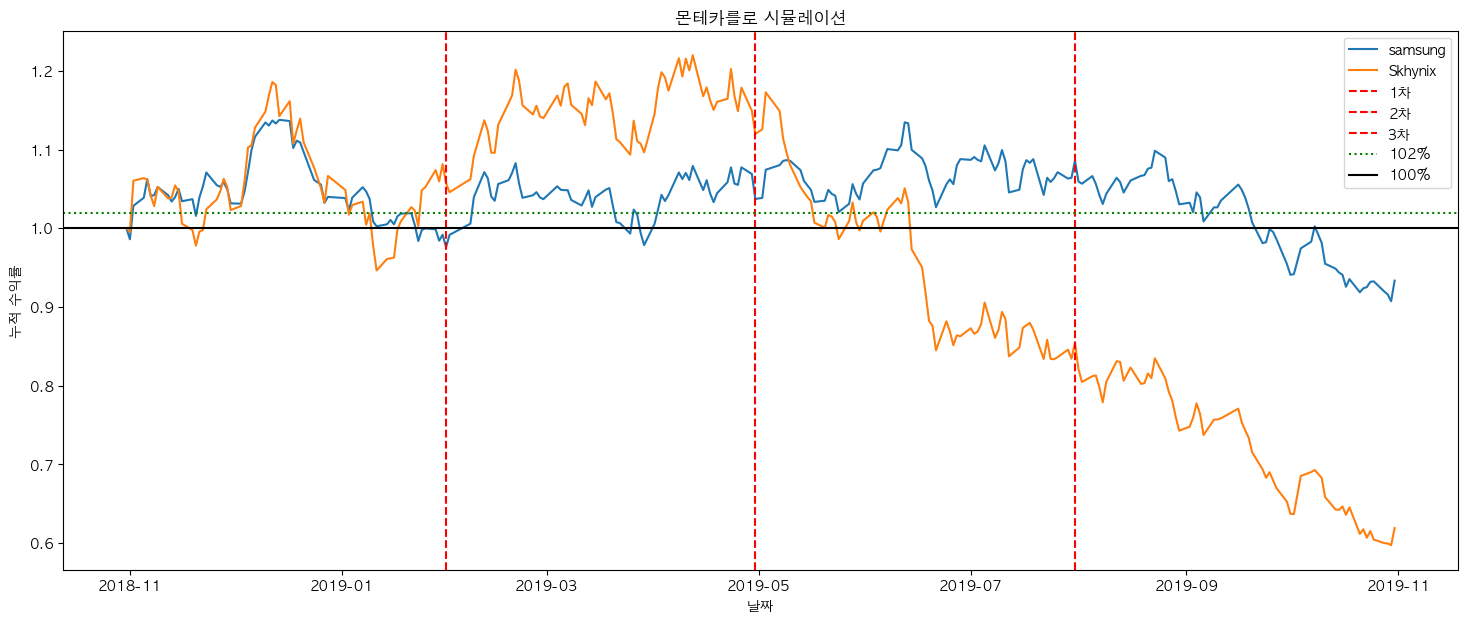

In [15]:
df_idx = df.iloc[252:, :]

# 결과 시각화
plt.figure(figsize=(18, 7))
plt.plot(df_idx.index, simulated_S[3, 0], label='samsung')
plt.plot(df_idx.index, simulated_S[3, 1], label='Skhynix')
plt.title('몬테카를로 시뮬레이션')
plt.xlabel('날짜')
plt.ylabel('누적 수익률')

# 세로줄 추가
plt.axvline(first, color='red', linestyle='--', label='1차')
plt.axvline(second, color='red', linestyle='--', label='2차')
plt.axvline(third, color='red', linestyle='--', label='3차')

# 가로줄 추가
plt.axhline(y=1.02, color='green', linestyle=':', label='102%')
plt.axhline(y=1.00, color='black', linestyle='-', label='100%')

plt.legend()
plt.show()

/var/folders/zp/_86qtd3j3ms644g4k0pnwc_c0000gn/T/ipykernel_15300/69992496.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_idx['samsung_cumulative_returns'] = (df_idx['samsung'] / df_idx['samsung'].iloc[0]).cumprod()
/var/folders/zp/_86qtd3j3ms644g4k0pnwc_c0000gn/T/ipykernel_15300/69992496.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_idx['skynix_cumulative_returns'] = (df_idx['skhynix'] / df_idx['skhynix'].iloc[0]).cumprod()


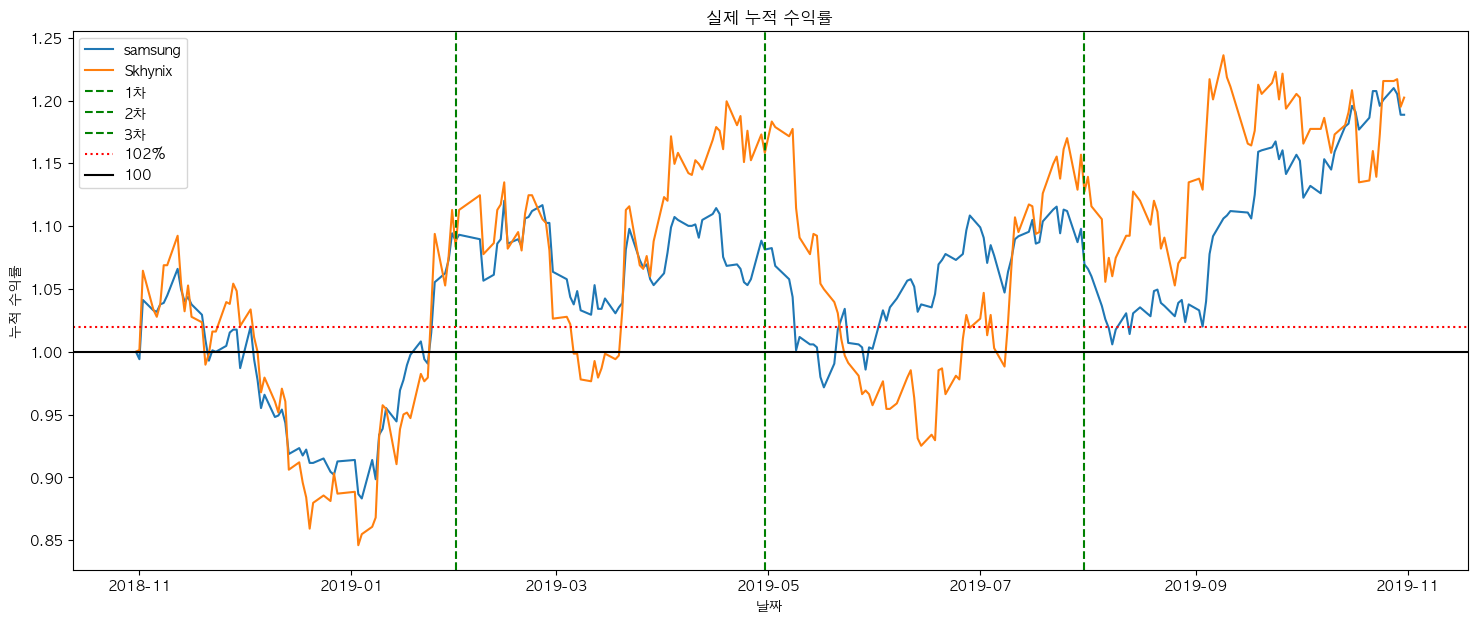

In [16]:
df_idx['samsung_cumulative_returns'] = (df_idx['samsung'] / df_idx['samsung'].iloc[0]).cumprod()
df_idx['skynix_cumulative_returns'] = (df_idx['skhynix'] / df_idx['skhynix'].iloc[0]).cumprod()

# 결과 시각화
plt.figure(figsize=(18, 7))
plt.plot(df_idx.index, df_idx['samsung_cumulative_returns'].pct_change().fillna(0) + 1.0, label='samsung')
plt.plot(df_idx.index, df_idx['skynix_cumulative_returns'].pct_change().fillna(0) + 1.0, label='Skhynix')
plt.title('실제 누적 수익률')
plt.xlabel('날짜')
plt.ylabel('누적 수익률')

# 세로줄 추가 (예: x=50일 때)
plt.axvline(first, color='green', linestyle='--', label='1차')
plt.axvline(second, color='green', linestyle='--', label='2차')
plt.axvline(third, color='green', linestyle='--', label='3차')

# 가로줄 추가 (예: y=0.2일 때)
plt.axhline(y=1.02, color='red', linestyle=':', label='102%')
plt.axhline(y=1.00, color='black', linestyle='-', label='100')

plt.legend()
plt.show()

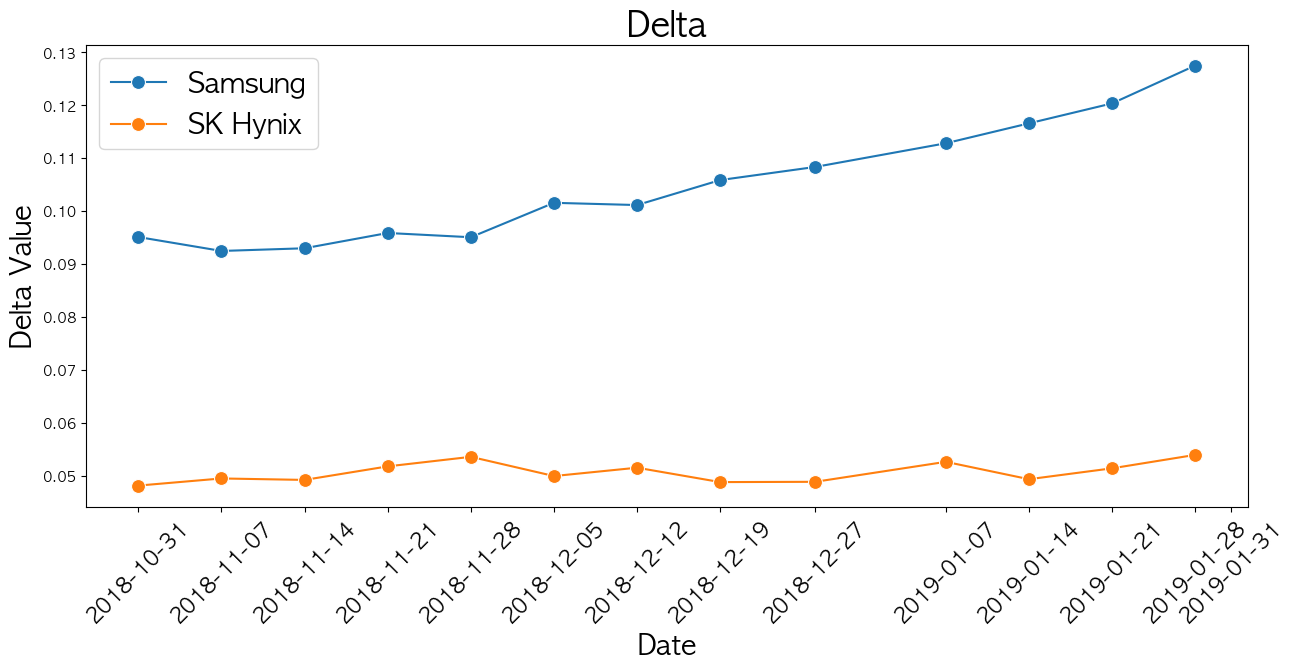

In [17]:
# 델타 그래프 그리기
import seaborn as sns
import matplotlib.pyplot as plt

# 꺾은선 그래프 그리기
plt.figure(figsize=(15, 6))
sns.lineplot(data=total, x=total.index, y='samsung_delta', color='C0', label='Samsung', marker='o', markersize=10)
sns.lineplot(data=total, x=total.index, y='skhynix_delta', color='C1', label='SK Hynix', marker='o', markersize=10)

xticks_indices = [i for i in range(0, len(total.index))]
xticks_labels = total.index[xticks_indices].strftime('%Y-%m-%d')
# y_ticks = np.arange(35000, 100000, 5000)

plt.xticks(xticks_labels, fontsize=15, rotation = 45)

plt.yticks(fontsize=10)
plt.title('Delta', fontsize=25)
plt.xlabel('Date', fontsize=20)
plt.ylabel('Delta Value', fontsize=20)

plt.legend(fontsize=20, loc='upper left')
plt.show()

In [18]:
total['samsung_stock_chage'] = total['samsung_stock_nums'].diff()
total['skhynix_stock_chage'] = total['skhynix_stock_nums'].diff()

In [19]:
total['samsung_stock_chage'].fillna(0, inplace=True)
total['skhynix_stock_chage'].fillna(0, inplace=True)

In [20]:
total['samsung_delta_change'].iloc[0] = 0
total['skhynix_delta_change'].iloc[0] = 0

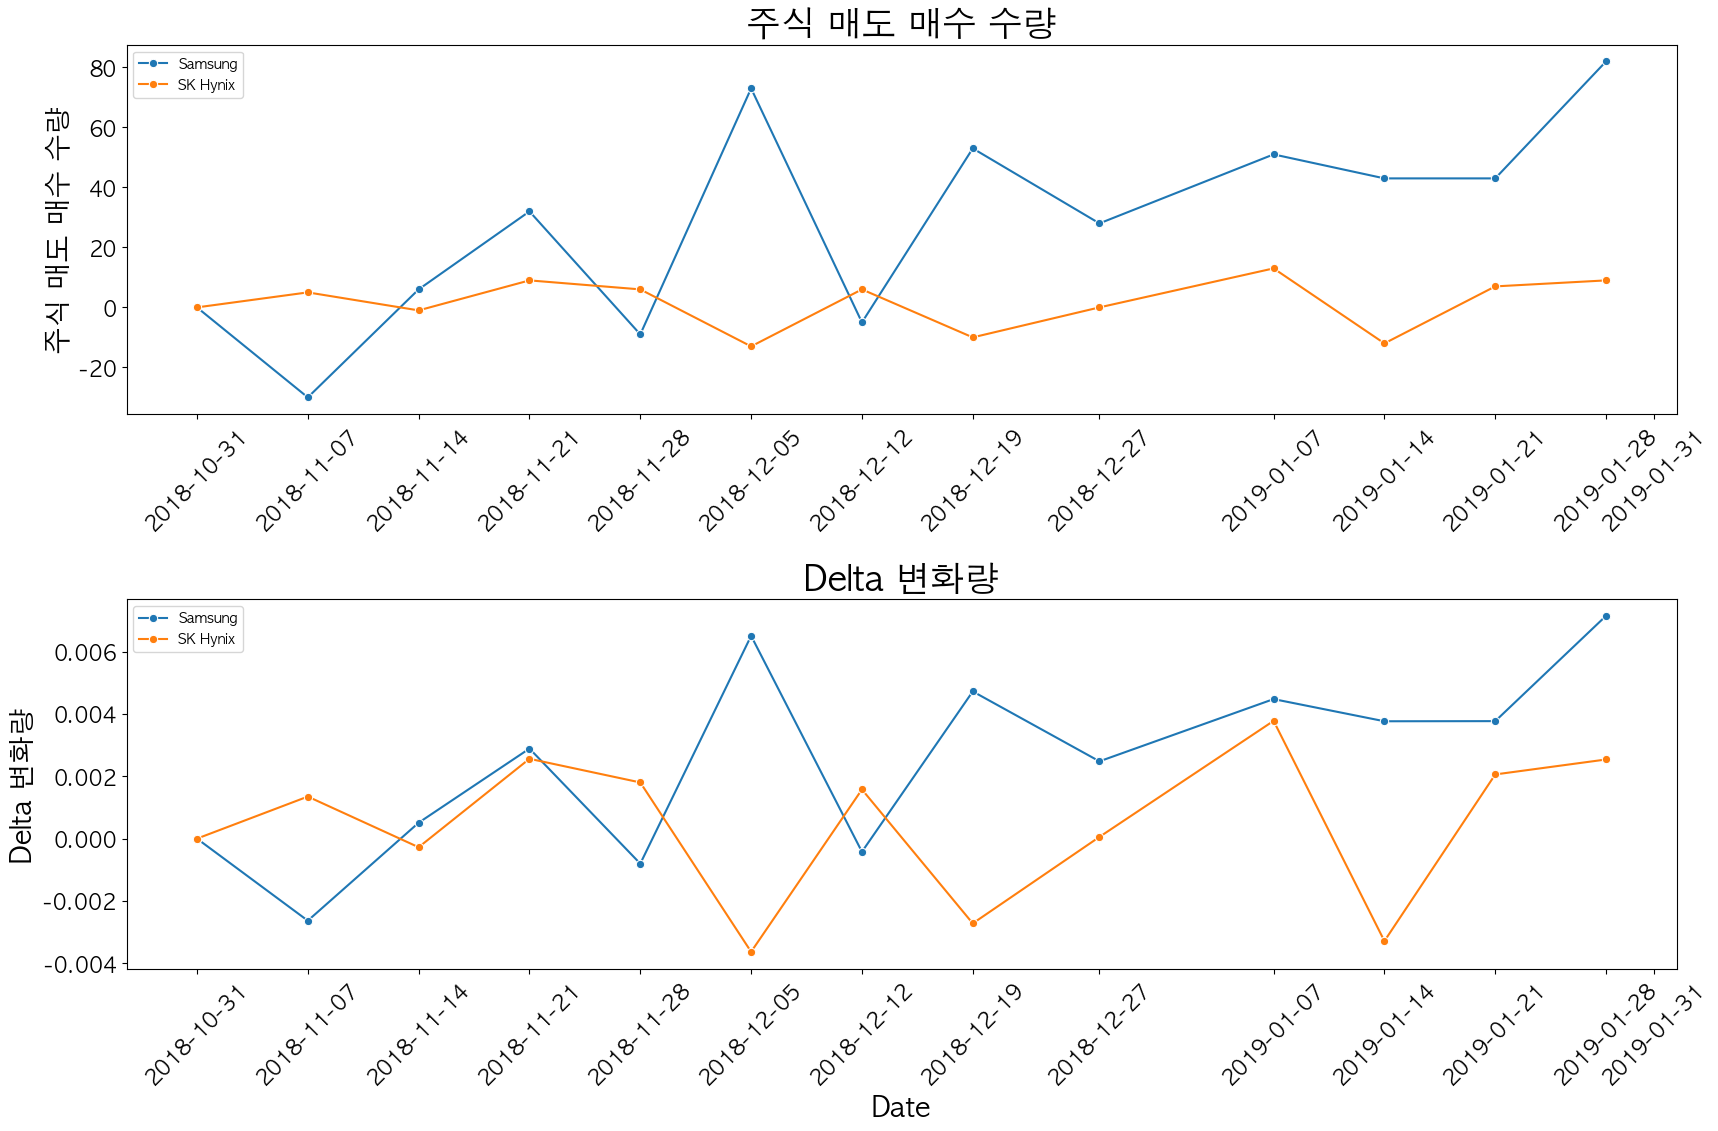

In [21]:
# 주식 매도 매수 수량
plt.figure(figsize=(20, 12))

plt.subplot(2, 1, 1)
ax1 = sns.lineplot(data=total.iloc[:-1, :], x=total.iloc[:-1, :].index, y='samsung_stock_chage', color='C0', label='Samsung', marker='o')
sns.lineplot(data=total.iloc[:-1, :], x=total.iloc[:-1, :].index, y='skhynix_stock_chage', color='C1', label='SK Hynix', marker='o')
# ax1.set_xlabel('Date', fontsize=20)
ax1.set_xlabel(' ', fontsize=20)
ax1.set_ylabel('주식 매도 매수 수량', fontsize=20)
ax1.set_title('주식 매도 매수 수량', fontsize=25)
ax1.set_xticks(xticks_labels)  # 수정된 부분
ax1.tick_params(axis='x', labelsize=15,labelrotation=45)
ax1.tick_params(axis='y', labelsize=15)

plt.subplot(2, 1, 2)
ax2 = sns.lineplot(data=total.iloc[:-1, :], x=total.iloc[:-1, :].index, y='samsung_delta_change', color='C0', label='Samsung', marker='o')
sns.lineplot(data=total.iloc[:-1, :], x=total.iloc[:-1, :].index, y='skhynix_delta_change', color='C1', label='SK Hynix', marker='o')
ax2.set_xlabel('Date', fontsize=20)
ax2.set_ylabel('Delta 변화량', fontsize=20)
ax2.set_title('Delta 변화량', fontsize=25)
ax2.set_xticks(xticks_labels)  # 수정된 부분
ax2.tick_params(axis='x',labelsize=15, labelrotation=45)
ax2.tick_params(axis='y', labelsize=15)

# subplot 간의 간격 조절
plt.subplots_adjust(hspace=0.5)

plt.show()


In [22]:
# 총자산 수익률
imp = pd.DataFrame(total['total_money'] / 10000000000)


(array([0.99 , 0.995, 1.   , 1.005, 1.01 , 1.015, 1.02 ]),
 [Text(0, 0.99, '0.990'),
  Text(0, 0.995, '0.995'),
  Text(0, 1.0, '1.000'),
  Text(0, 1.005, '1.005'),
  Text(0, 1.01, '1.010'),
  Text(0, 1.015, '1.015'),
  Text(0, 1.02, '1.020')])

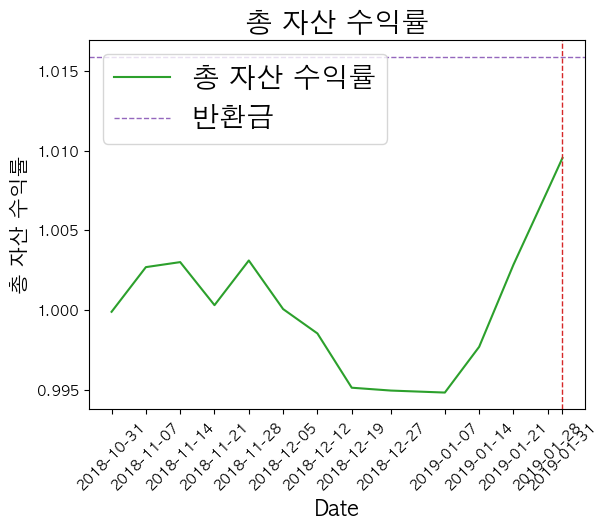

In [23]:
plt.plot(figsize=(15, 6))
plt.plot(imp, label='총 자산 수익률', color='C2')
plt.xlabel('Date', fontsize=15)
plt.ylabel('총 자산 수익률', fontsize=15)
plt.title('총 자산 수익률', fontsize=20)
plt.axvline(x=first_date, color='C3', linewidth=1, linestyle='--')
plt.axhline(y=1.0159, color='C4', linewidth=1, linestyle='--', label='반환금')
plt.legend(fontsize=20, loc='upper left')

plt.xticks(imp.index, fontsize=10, rotation = 45)
plt.yticks(fontsize=10)

In [24]:
# 총자산 수익률
imp = pd.DataFrame(total['total_money'] / 10000000000) - 1.0159

(array([-0.025, -0.02 , -0.015, -0.01 , -0.005,  0.   ,  0.005]),
 [Text(0, -0.025, '-0.025'),
  Text(0, -0.02, '-0.020'),
  Text(0, -0.015000000000000001, '-0.015'),
  Text(0, -0.010000000000000002, '-0.010'),
  Text(0, -0.005000000000000001, '-0.005'),
  Text(0, 0.0, '0.000'),
  Text(0, 0.0049999999999999975, '0.005')])

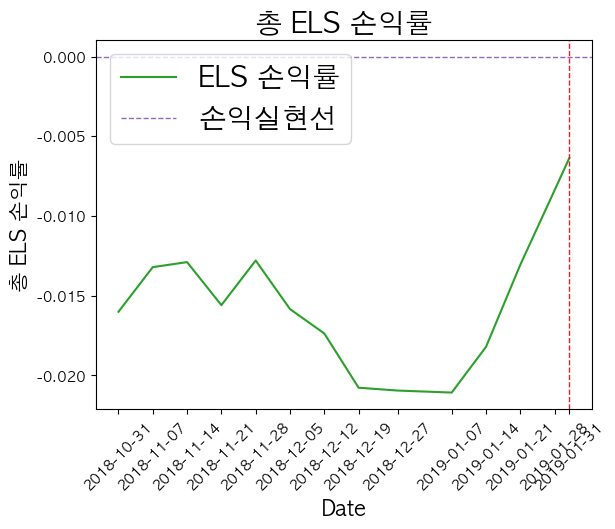

In [25]:
plt.plot(figsize=(15, 6))
plt.plot(imp, label='ELS 손익률', color='C2')
plt.xlabel('Date', fontsize=15)
plt.ylabel('총 ELS 손익률', fontsize=15)
plt.title('총 ELS 손익률', fontsize=20)
plt.axvline(x=first_date, color='C3', linewidth=1, linestyle='--')
plt.axhline(y=0, color='C4', linewidth=1, linestyle='--', label='손익실현선')
plt.legend(fontsize=20, loc='upper left')

plt.xticks(imp.index, fontsize=10, rotation = 45)
plt.yticks(fontsize=10)